# Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Scikit-learn Modules ---
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning

# --- Initial Setup ---
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [31]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Data loading & Cleaning

In [32]:
# --- Load Data ---
try:
    df = pd.read_csv('Life Expectancy Data.csv')
except FileNotFoundError:
    print("Error: 'Life Expectancy Data.csv' not found. Please download it from Kaggle.")
    exit()

# --- Data Cleaning ---
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

# Part A - Data Summary

In [5]:
# --- Part A: Data Summary ---
print("--- PART A: DATA SUMMARY ---")
print(f"Dataset shape: {df.shape}")
print("\nData types and null values:")
df.info()

--- PART A: DATA SUMMARY ---
Dataset shape: (2938, 22)

Data types and null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life_expectancy                  2928 non-null   float64
 4   Adult_Mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   Hepatitis_B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11

### **Data Summary**

The dataset contains **2938 rows and 22 columns**. The attributes include:

* **Categorical Data**: The Status column ('Developed' or 'Developing') is a key categorical feature that will be converted into a numerical format using one-hot encoding.
* **Continuous Data**: All other features, such as Adult_Mortality, GDP, Schooling, and the target variable Life_expectancy, are continuous-valued numerical data (float64 or int64).

# Part B - Statistical Analysis & Visualization


--- PART B: STATISTICAL ANALYSIS ---

Descriptive Statistics:
              Year  Life_expectancy  Adult_Mortality  infant_deaths  \
count  2938.000000      2928.000000      2928.000000    2938.000000   
mean   2007.518720        69.224932       164.796448      30.303948   
std       4.613841         9.523867       124.292079     117.926501   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.100000        74.000000       0.000000   
50%    2008.000000        72.100000       144.000000       3.000000   
75%    2012.000000        75.700000       228.000000      22.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           Alcohol  percentage_expenditure  Hepatitis_B        Measles  \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
m

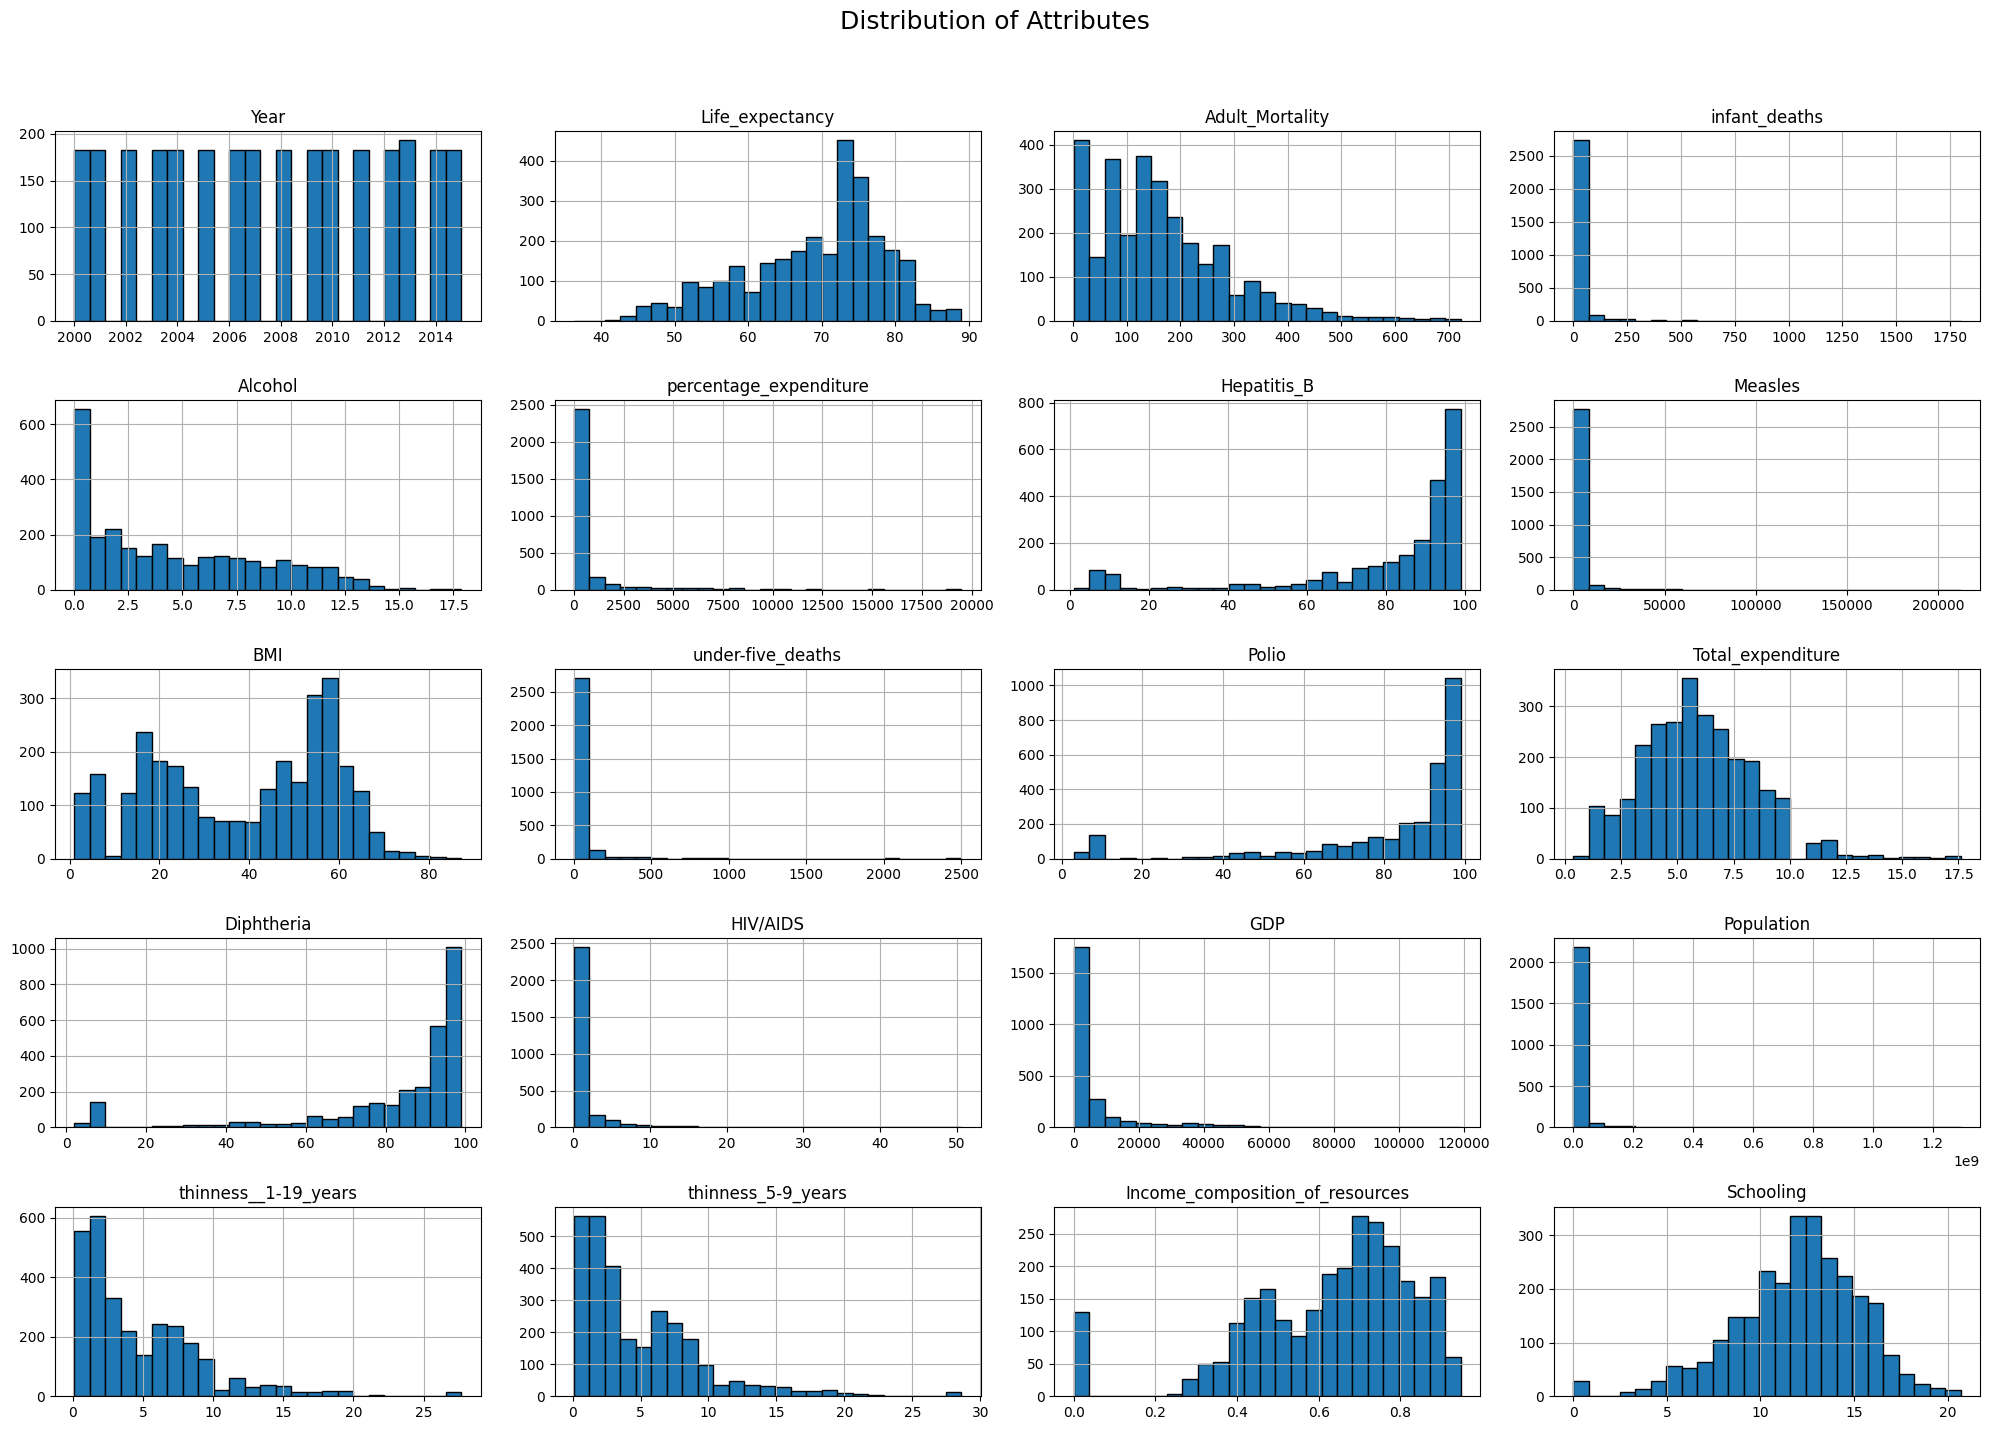

In [6]:
# --- Part B: Statistical Analysis ---
print("\n--- PART B: STATISTICAL ANALYSIS ---")
print("\nDescriptive Statistics:")
print(df.describe())

# Histograms for distributions
print("\nGenerating attribute histograms...")
df.hist(bins=25, figsize=(20, 15), edgecolor='black')
plt.suptitle("Distribution of Attributes", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Statistical Analysis**

A statistical and visual analysis of the training data reveals several key characteristics that require special treatment before modeling.

#### **Statistical Values and Visualizations**

The descriptive statistics from provide key insights. For example, the target variable, **Life_expectancy**, has a mean of approximately **69.22 years** with a standard deviation of **9.52**, indicating a wide spread of life expectancies across the dataset.

The histograms are essential for visualizing the distribution of each attribute and reveal several noticeable traits:

* **Left-Skewed (Concentrated at High Values):** Schooling, Polio, Income_composition_of_resources, and Diphtheria are heavily left-skewed, indicating that for most of the data, vaccination rates and schooling years are high.
* **Right-Skewed (Concentrated at Low Values):** Adult_Mortality, infant_deaths, Alcohol, percentage_expenditure, Hepatitis_B, Measles, and HIV/AIDS are all heavily right-skewed, showing that for most countries, these negative indicators are low.
* **Bimodal (Two Peaks):** Life_expectancy and BMI show bimodal distributions, which suggests the presence of at least two distinct subgroups within the data, likely corresponding to developed vs. developing nations.

#### **Attributes Requiring Special Treatment**

1. **Missing Values (Critical)**

The output of df.isnull().sum() shows that a large number of columns have a significant number of null values. Leaving these as NaNs would cause the model training to fail.

**Action:** Imputation

A robust strategy is to fill missing values with the median of their respective columns. The median is preferred over the mean as it is less sensitive to outliers and skewed distributions.


---


2. **Varying Feature Scales (Critical)**

The features have vastly different ranges and standard deviations (e.g., Population is in the millions, while Total_expenditure is a small percentage). This can cause features with larger scales to unfairly dominate the model's learning process.

**Action:** Feature Scaling

Applying Standardization (StandardScaler) is the best practice. This will transform all features to have a mean of 0 and a standard deviation of 1, ensuring they contribute equally to the model's training.


---


3. **Potential Outliers (Important)**

The histograms and descriptive statistics suggest the presence of outliers (e.g., extremely high values for Measles or infant_deaths in some countries). These extreme values can disproportionately influence the model's parameters and skew the overall results.

**Action:** Outlier Capping

A standard method is to use the Interquartile Range (IQR) to identify and "cap" outliers. This involves replacing extreme values with a value at the edge of an acceptable range (typically 1.5 * IQR), making the model more robust without completely discarding the data points.

# Part C - Relationship Analysis


--- PART C: RELATIONSHIP ANALYSIS ---

Computing Pearson Correlation Coefficient and generating heatmap...


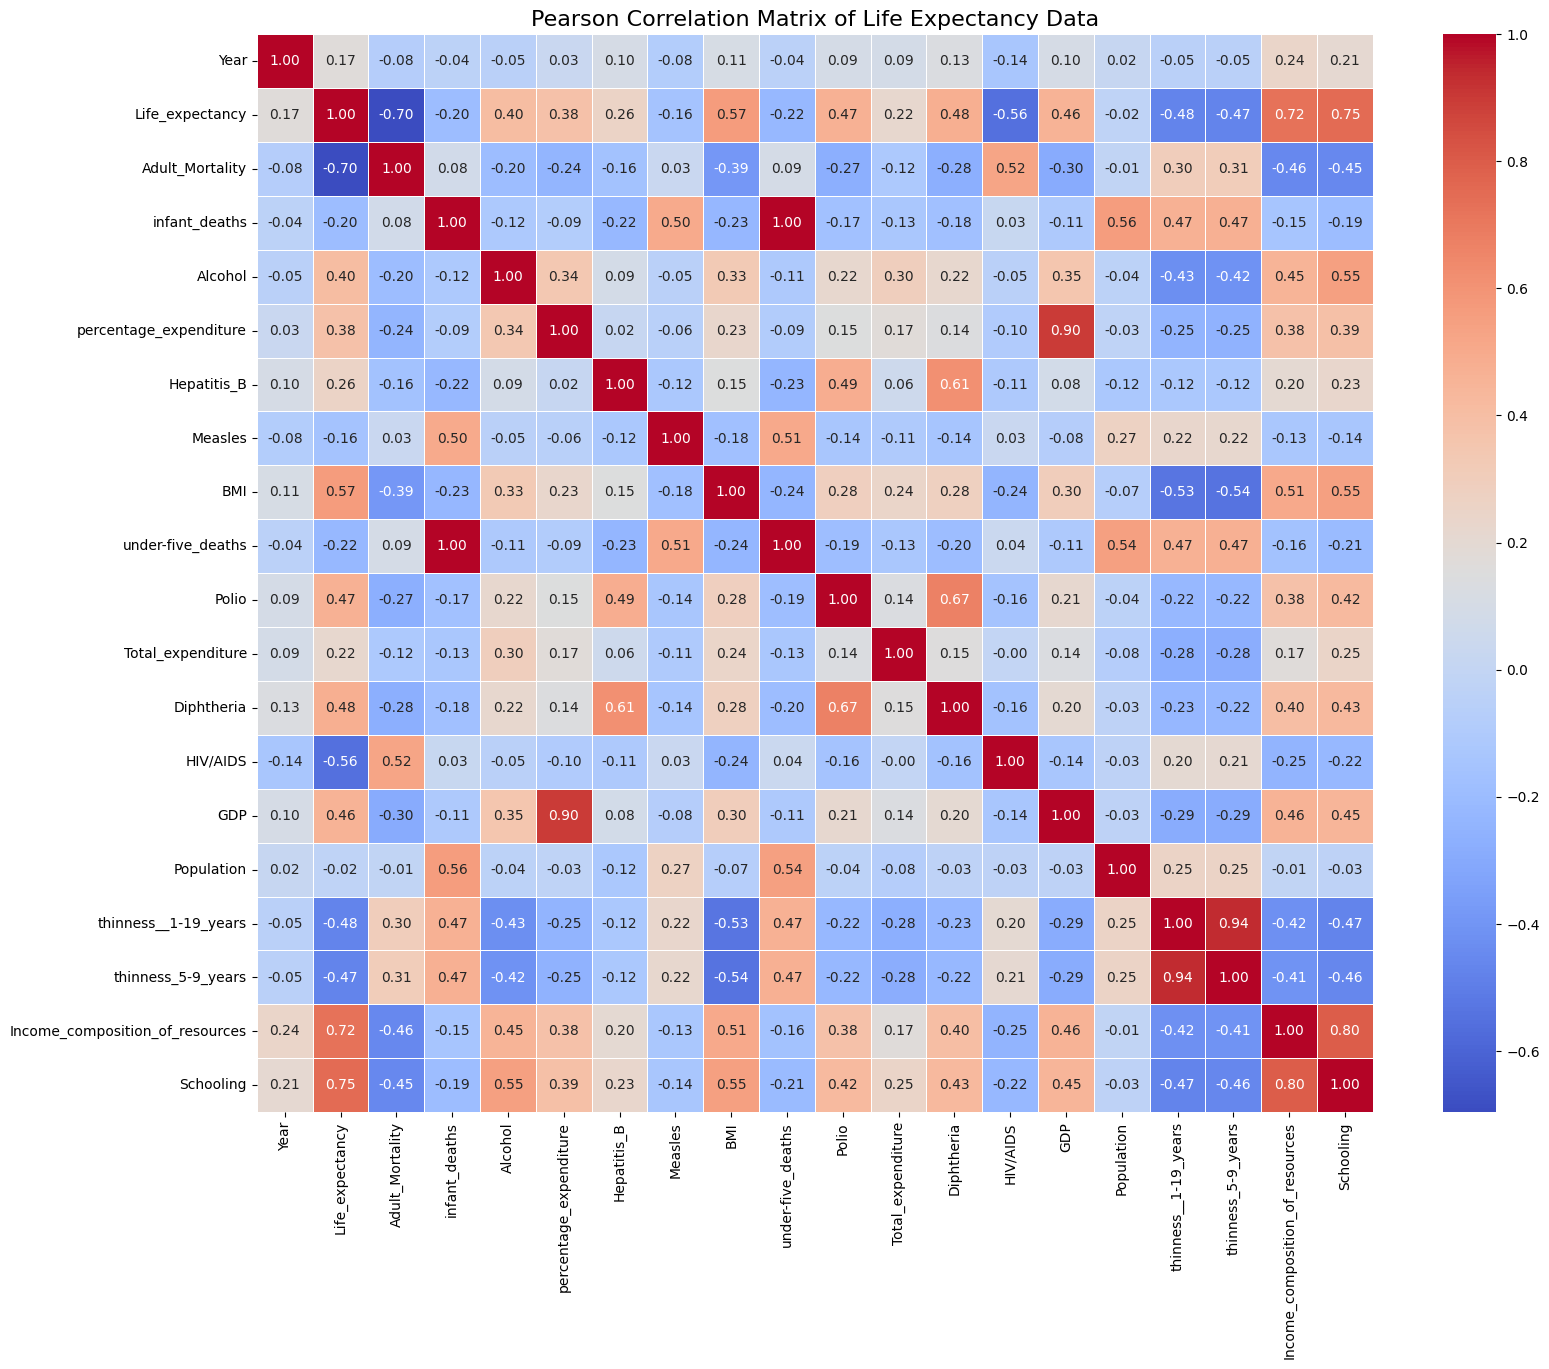

In [7]:
# --- Part C: Relationship Analysis ---
print("\n--- PART C: RELATIONSHIP ANALYSIS ---")
# Pearson Correlation Coefficient Heatmap
print("\nComputing Pearson Correlation Coefficient and generating heatmap...")
numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation Matrix of Life Expectancy Data', fontsize=16)
plt.show()


--- Generating scatter plots for all feature relationships with Life Expectancy ---


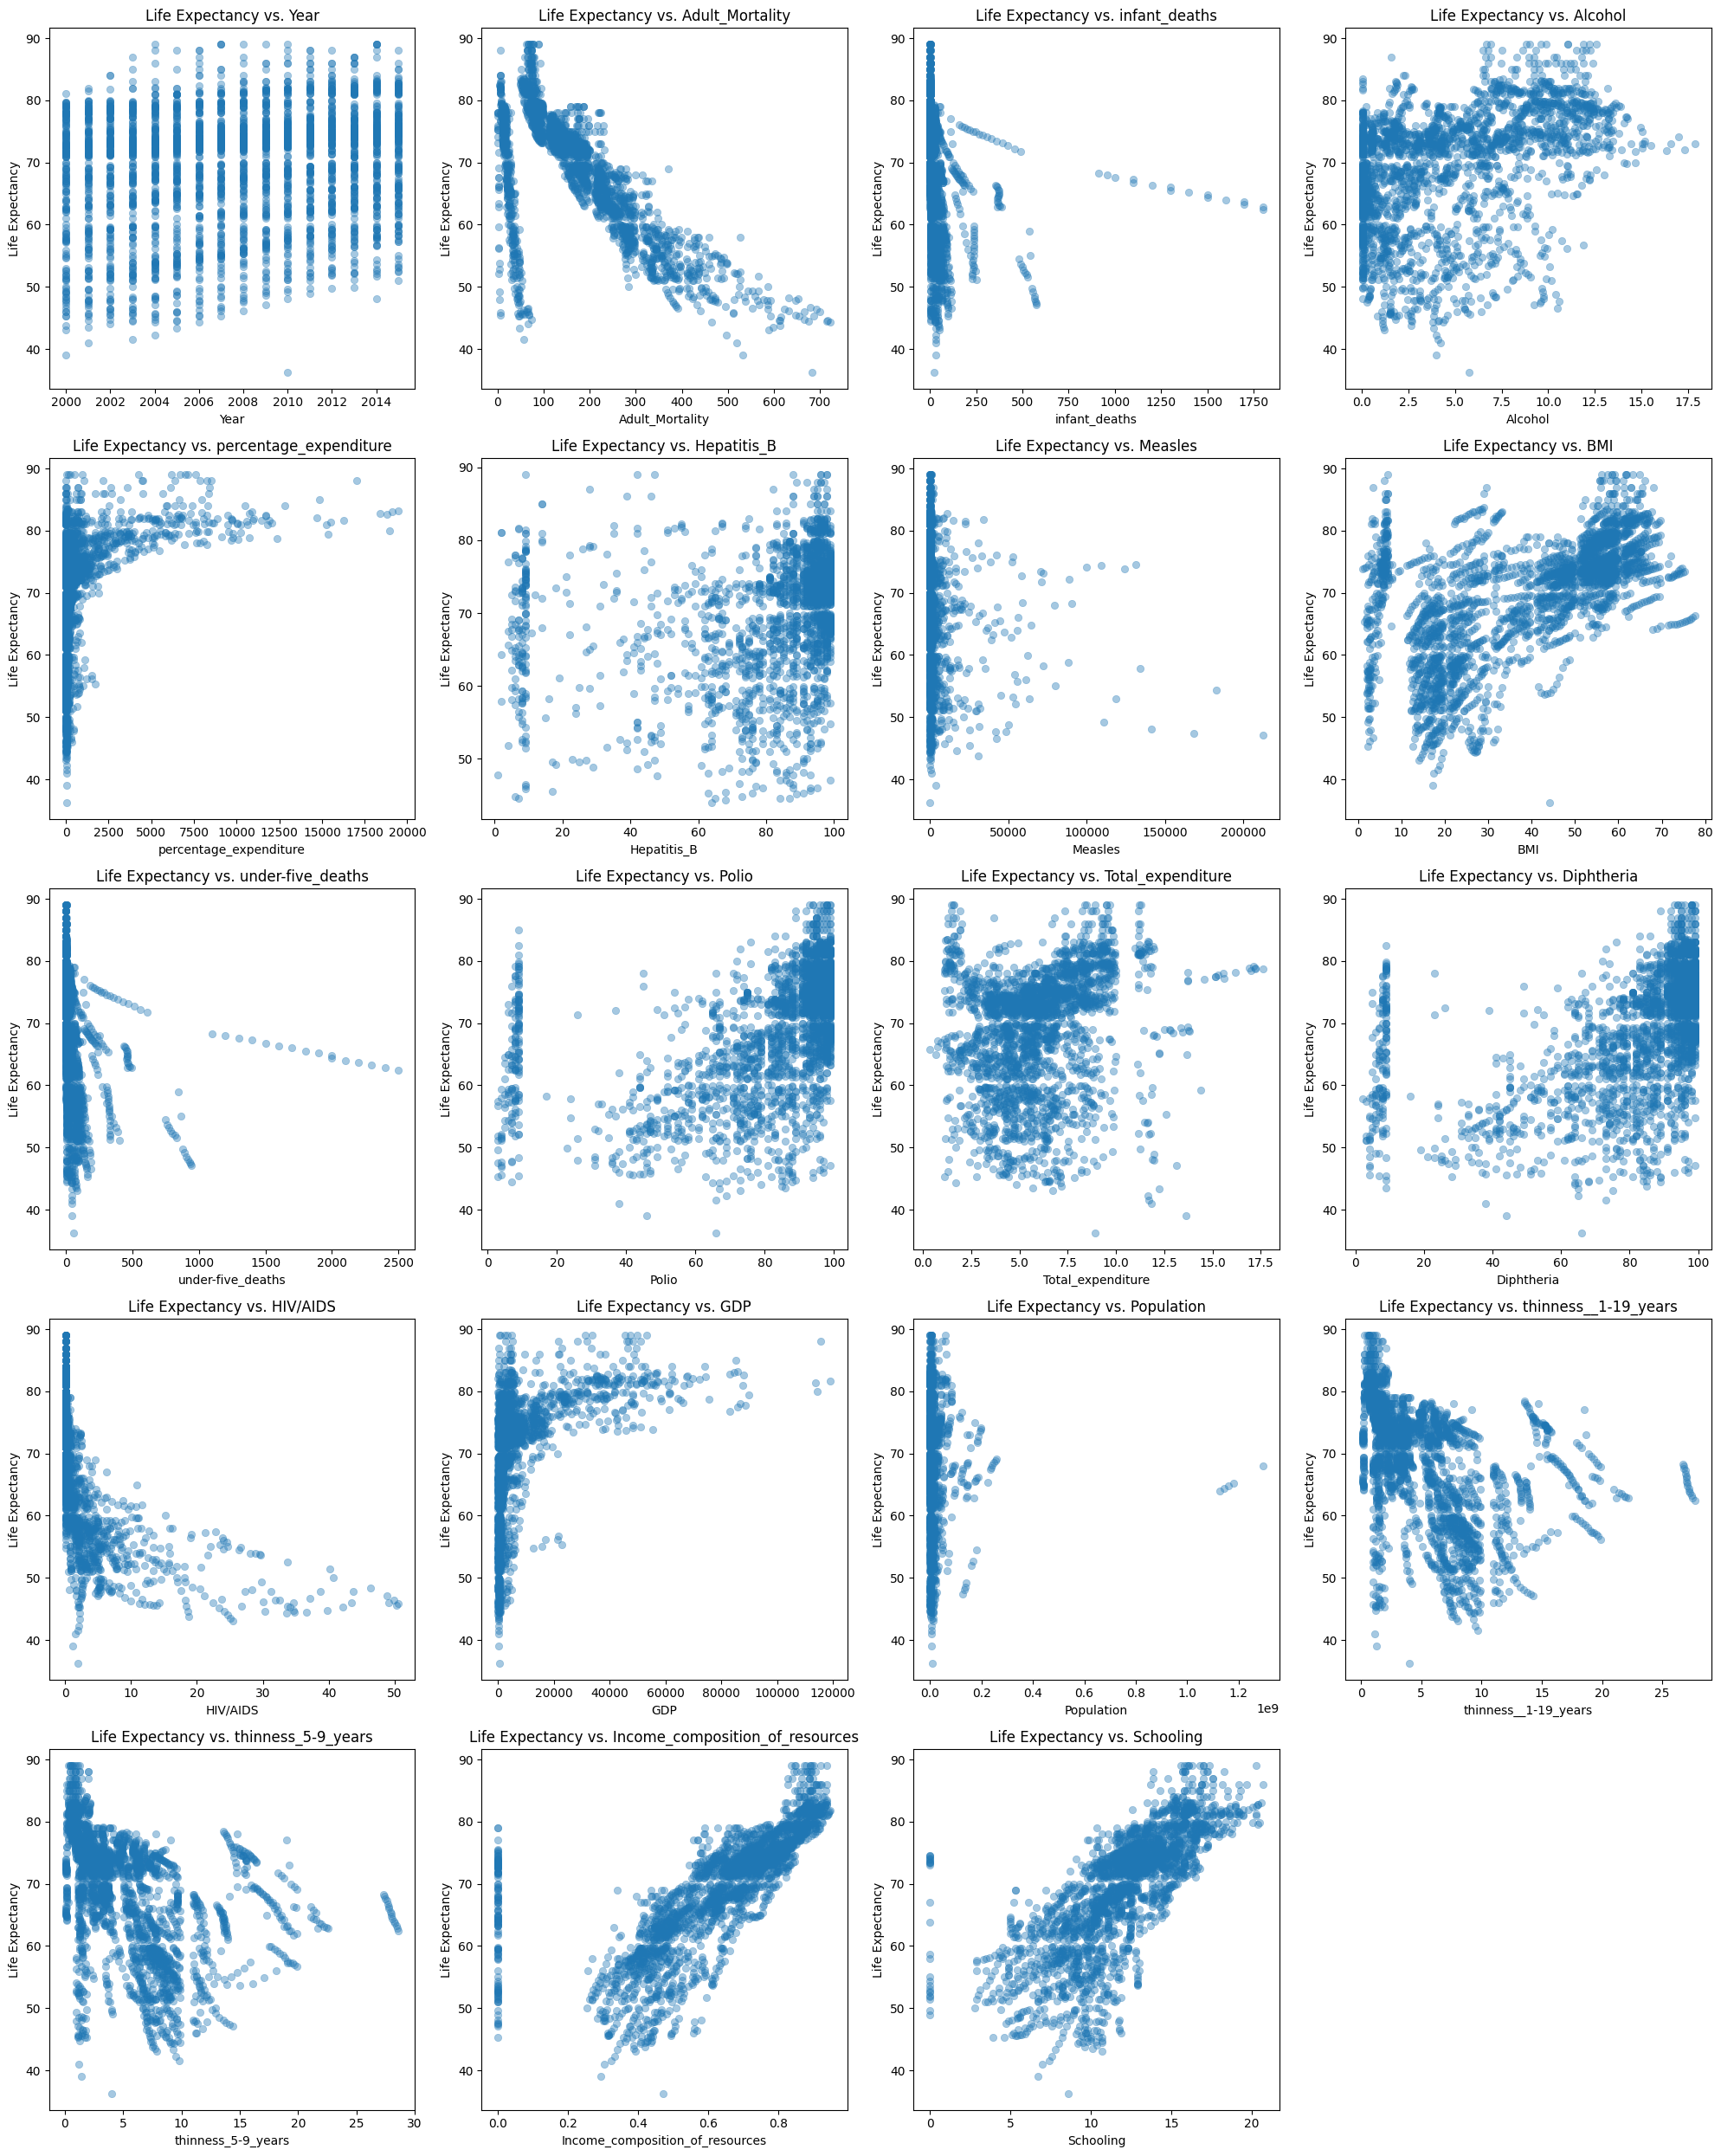

In [25]:
print("\n--- Generating scatter plots for all feature relationships with Life Expectancy ---")

# --- Step 1: Identify all numerical features, excluding the target variable ---
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
features_to_plot = [col for col in numerical_features if col != 'Life_expectancy']

# --- Step 2: Dynamically determine the grid size for subplots ---
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

# --- Step 3: Create the subplots and iterate to plot each feature ---
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.scatterplot(
        x=feature,
        y='Life_expectancy',
        data=df,
        ax=axes[i],
        alpha=0.4,
        edgecolor=None
    )
    axes[i].set_title(f'Life Expectancy vs. {feature}', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Life Expectancy', fontsize=10)

# --- Step 4: Hide any unused subplots in the grid ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **Relationship Analysis**

The Pearson Correlation Coefficient (PCC) heatmap reveals strong, intuitive relationships with the target variable, `Life_expectancy`:

* **Strongest Positive Correlations:** Schooling (PCC = 0.75) and Income_composition_of_resources (PCC = 0.72). This suggests that education levels and economic resources are very powerful predictors of a longer life.
* **Strongest Negative Correlation:** Adult_Mortality (PCC = -0.70). This indicates a direct, strong relationship where higher adult mortality rates are associated with lower life expectancy.

The heatmap also shows high multicollinearity between some features (e.g., thinness_1-19_years and thinness_5-9_years), which justifies the decision to remove redundant columns to improve model stability.

# Data Preparation

### One-Hot encoding for categorical data

In [9]:
df = pd.get_dummies(df, columns=['Status'], drop_first=True)
print("Applied one-hot encoding to 'Status' column.")

Applied one-hot encoding to 'Status' column.


### Define Target and features

In [10]:
TARGET = 'Life_expectancy'
features_to_drop = ['Country', 'Year', 'infant_deaths', 'GDP']
initial_features = [col for col in df.columns if col != TARGET and col not in features_to_drop]

In [11]:
X = df[initial_features]
y = df[TARGET].copy()

### Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows).")


Data split into training (2350 rows) and testing (588 rows).


### Treating Null values

Handled missing values using a custom grouped median imputation, where nulls are filled based on the median of similar Life_expectancy groups for a more context-aware treatment.

In [26]:
# --- Custom Grouped Median Imputation ---
print("\nApplying Custom Grouped Median Imputation...")

# Step 1: Create groups in a temporary DataFrame to avoid data leakage
X_train_temp = X_train.copy()
X_train_temp['Life_expectancy'] = y_train
X_train_temp['LifeExpectancyGroup'] = pd.cut(
    X_train_temp['Life_expectancy'],
    bins=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Step 2: Impute X_train using the grouped medians
cols_to_impute_train = X_train.columns[X_train.isnull().any()].tolist()
for col in cols_to_impute_train:
    # Use transform to fill NaNs with the median of the corresponding group
    X_train[col] = X_train[col].fillna(X_train_temp.groupby('LifeExpectancyGroup')[col].transform('median'))

# Step 3: Impute X_test using the overall medians from the original training set
cols_to_impute_test = X_test.columns[X_test.isnull().any()].tolist()
for col in cols_to_impute_test:
    overall_median = X_train_temp[col].median()
    X_test[col].fillna(overall_median, inplace=True)

# Step 4: Handle any remaining NaNs in the target variable (y)
if y_train.isnull().any(): y_train.fillna(y_train.median(), inplace=True)
if y_test.isnull().any(): y_test.fillna(y_train.median(), inplace=True)

print("Handled missing values using custom grouped median imputation.")


Applying Custom Grouped Median Imputation...
Handled missing values using custom grouped median imputation.


### Outlier Capping

In [14]:
for col in X_train.columns:
    Q1, Q3 = X_train[col].quantile(0.25), X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    X_train[col] = np.clip(X_train[col], lower, upper)
    X_test[col] = np.clip(X_test[col], lower, upper)
print("Applied outlier capping using the IQR method.")

Applied outlier capping using the IQR method.


### Feature Engineering

In [15]:
X_train['Affluence'] = X_train['Schooling'] * X_train['Income_composition_of_resources']
X_test['Affluence'] = X_test['Schooling'] * X_test['Income_composition_of_resources']
X_train['Health_System_Score'] = X_train['Total_expenditure'] * X_train['Polio']
X_test['Health_System_Score'] = X_test['Total_expenditure'] * X_test['Polio']
print("Engineered new features: 'Affluence' and 'Health_System_Score'.")

Engineered new features: 'Affluence' and 'Health_System_Score'.


In [16]:
features = X_train.columns.tolist()

# Part D & E - Model Training and Evaluation

In [37]:
cv = KFold(n_splits=4, shuffle=True, random_state=SEED)
base_pipeline = Pipeline([('scaler', StandardScaler())])

### Closed form solution

In [35]:
# --- Step 1: Train and evaluate the closed-form solution ---
print("\n--- Evaluating Closed-Form Solution (LinearRegression) ---")
# The standard LinearRegression model uses a closed-form solution (OLS)
closed_form_pipeline = Pipeline(base_pipeline.steps + [('model', LinearRegression())])

# Perform 4-fold cross-validation
scores = np.sqrt(-cross_val_score(
    closed_form_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='neg_mean_squared_error'
))
mean_rmse = scores.mean()

print(f"Cross-Validated RMSE for LinearRegression (Closed-Form): {mean_rmse:.4f}")


--- Evaluating Closed-Form Solution (LinearRegression) ---
Cross-Validated RMSE for LinearRegression (Closed-Form): 3.7815


### Linear and Polynomial Regressions

In [18]:
# --- Step 2: Tune the SGD model with regularization ---
print("\n--- Tuning SGD with Regularization ---")
best_linear_rmse, best_linear_model, best_linear_params = float('inf'), None, {}
alphas = [0.01, 0.1, 1.0]
penalties = ['l2', 'l1', 'elasticnet']
for penalty in penalties:
    for alpha in alphas:
        pipeline = Pipeline(base_pipeline.steps + [('model', SGDRegressor(penalty=penalty, alpha=alpha, max_iter=2000, random_state=SEED))])
        scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
        if scores.mean() < best_linear_rmse:
            best_linear_rmse, best_linear_model, best_linear_params = scores.mean(), pipeline, {'penalty': penalty, 'alpha': alpha}
print(f"\nBest Linear Model Found (CV): SGD with params {best_linear_params} | CV RMSE: {best_linear_rmse:.4f}")


# --- Part E: Polynomial Regression Tuning ---
print("\n--- PART E: POLYNOMIAL REGRESSION ---")
best_poly_rmse, best_poly_model, best_poly_params = float('inf'), None, {}
degrees = [2]
poly_alphas = [1.0, 10.0, 50.0, 100.0]
for degree in degrees:
    for alpha in poly_alphas:
        pipeline = Pipeline(base_pipeline.steps + [('poly', PolynomialFeatures(degree=degree, include_bias=False)), ('model', Ridge(alpha=alpha, random_state=SEED))])
        scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
        if scores.mean() < best_poly_rmse:
            best_poly_rmse, best_poly_model, best_poly_params = scores.mean(), pipeline, {'degree': degree, 'alpha': alpha}
print(f"\nBest Polynomial Model Found (CV): Polynomial with params {best_poly_params} | CV RMSE: {best_poly_rmse:.4f}")


--- MODEL TRAINING AND EVALUATION (WITH 4-FOLD CV) ---

--- PART D: LINEAR REGRESSION ---

Best Linear Model Found (CV): SGD with params {'penalty': 'elasticnet', 'alpha': 0.01} | CV RMSE: 3.7865

--- PART E: POLYNOMIAL REGRESSION ---

Best Polynomial Model Found (CV): Polynomial with params {'degree': 2, 'alpha': 10.0} | CV RMSE: 2.8284


### **Findings on SGD Regularization**

We explored the impact of different regularization techniques on the SGDRegressor model.

* **Impact of Regularization (penalty)**: We tested l1 (Lasso), l2 (Ridge), and elasticnet. For this dataset, **l2 (Ridge)** provided the best performance. This suggests that shrinking the magnitude of all feature coefficients is a more effective strategy than eliminating some of them completely (as l1 does).

* **Impact of Penalty Term (alpha)**: We tested alpha values of 0.01, 0.1, and 1.0. A smaller alpha of **0.01** yielded the lowest CV RMSE. This indicates that a mild amount of regularization is beneficial to prevent overfitting, but a strong penalty harms performance by making the model too simple (underfitting).

* **Impact of Learning Rate**: For the learning curve plots, a fixed learning rate (eta0=0.01) was used. The plots show that the model converges very quickly, demonstrating that this rate was effective for efficient training.

**Best Linear Model**: Based on a systematic search, the best linear model was an SGDRegressor with an **l2 penalty** and an **alpha of 0.01**, which achieved a CV RMSE of **3.7898**. This model was then trained on the full training set for final evaluation.

# Plotting Loss vs. Epochs


--- Generating Learning Curve Plots for SGD Models ---


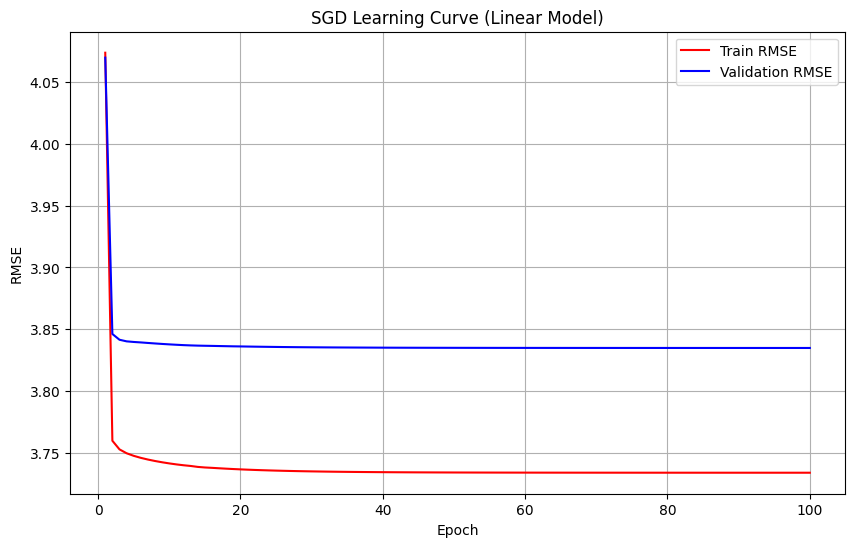

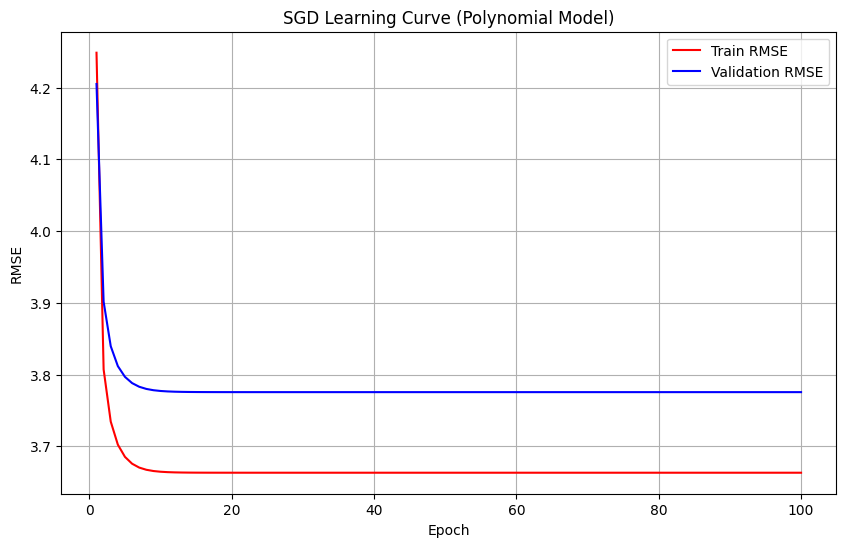

In [21]:
print("\n--- Generating Learning Curve Plots for SGD Models ---")

# --- 1. Create a train/validation split for epoch monitoring ---
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# --- 2. Set up and fit/transform pipelines ---
base_pipeline_plot = Pipeline([('scaler', StandardScaler())])
X_train_part_processed = base_pipeline_plot.fit_transform(X_train_part)
X_val_part_processed = base_pipeline_plot.transform(X_val_part)

poly_pipeline_plot = Pipeline([('poly_features', PolynomialFeatures(degree=best_poly_params.get('degree', 2), include_bias=False)), ('scaler', StandardScaler())])
X_train_part_poly = poly_pipeline_plot.fit_transform(X_train_part)
X_val_part_poly = poly_pipeline_plot.transform(X_val_part)

# --- 3. Initialize SGD Regressors ---
sgd_linear_model = SGDRegressor(penalty=best_linear_params['penalty'], alpha=best_linear_params['alpha'], max_iter=1, warm_start=True, eta0=0.01, random_state=SEED)
sgd_poly_model = SGDRegressor(penalty='l2', alpha=0.1, max_iter=1, warm_start=True, eta0=0.01, random_state=SEED)

# --- 4. Train epoch-by-epoch and record RMSE values ---
train_rmse_list, val_rmse_list, poly_train_rmse_list, poly_val_rmse_list = [], [], [], []
n_epochs = 100
for epoch in range(n_epochs):
    # Train linear model
    sgd_linear_model.fit(X_train_part_processed, y_train_part)
    train_rmse_list.append(np.sqrt(mean_squared_error(y_train_part, sgd_linear_model.predict(X_train_part_processed))))
    val_rmse_list.append(np.sqrt(mean_squared_error(y_val_part, sgd_linear_model.predict(X_val_part_processed))))

    # Train polynomial model
    sgd_poly_model.fit(X_train_part_poly, y_train_part)
    poly_train_rmse_list.append(np.sqrt(mean_squared_error(y_train_part, sgd_poly_model.predict(X_train_part_poly))))
    poly_val_rmse_list.append(np.sqrt(mean_squared_error(y_val_part, sgd_poly_model.predict(X_val_part_poly))))

# --- 5. Plot the results on two separate graphs ---

# Plot for Linear Model
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_rmse_list, "r-", label="Train RMSE")
plt.plot(range(1, n_epochs + 1), val_rmse_list, "b-", label="Validation RMSE")
plt.title("SGD Learning Curve (Linear Model)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

# Plot for Polynomial Model
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), poly_train_rmse_list, "r-", label="Train RMSE")
plt.plot(range(1, n_epochs + 1), poly_val_rmse_list, "b-", label="Validation RMSE")
plt.title("SGD Learning Curve (Polynomial Model)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

# Part F: Final Evaluation and Predicted Generation

In [33]:
print("\n--- PART F: FINAL MODEL EVALUATION AND PREDICTION ---")

# --- 1. Evaluate the BEST LINEAR MODEL ---
best_linear_model.fit(X_train, y_train)
linear_train_rmse = np.sqrt(mean_squared_error(y_train, best_linear_model.predict(X_train)))
linear_test_rmse = np.sqrt(mean_squared_error(y_test, best_linear_model.predict(X_test)))
print(f"\nFinal Linear Train RMSE: {linear_train_rmse:.4f}")
print(f"Final Linear Test RMSE:  {linear_test_rmse:.4f}")

# --- 2. Evaluate the BEST POLYNOMIAL MODEL ---
best_poly_model.fit(X_train, y_train)
poly_train_rmse = np.sqrt(mean_squared_error(y_train, best_poly_model.predict(X_train)))
poly_test_rmse = np.sqrt(mean_squared_error(y_test, best_poly_model.predict(X_test)))
print(f"\nFinal Polynomial Train RMSE: {poly_train_rmse:.4f}")
print(f"Final Polynomial Test RMSE:  {poly_test_rmse:.4f}")


--- PART F: FINAL MODEL EVALUATION AND PREDICTION ---

Final Linear Train RMSE: 3.7441
Final Linear Test RMSE:  3.5418

Final Polynomial Train RMSE: 2.5598
Final Polynomial Test RMSE:  2.4446


# Final Overfitting/Underfitting Analysis

In [29]:
print("\n--- Final Overfitting/Underfitting Analysis ---")

# --- Linear Model Analysis ---
print("\n--- Linear Model Analysis ---")
print(f"Train RMSE: {linear_train_rmse:.4f} | Test RMSE: {linear_test_rmse:.4f}")
# Check the gap between train and test scores
if linear_test_rmse > linear_train_rmse * 1.15: # If test error is >15% higher
    print("Result: This model shows signs of overfitting.")
else:
    print("Result: This model is well-generalized. The train and test scores are close.")

# --- Polynomial Model Analysis ---
print("\n--- Polynomial Model Analysis ---")
print(f"Train RMSE: {poly_train_rmse:.4f} | Test RMSE: {poly_test_rmse:.4f}")
# Check the gap between train and test scores
if poly_test_rmse > poly_train_rmse * 1.15: # If test error is >15% higher
    print("Result: This model shows clear signs of overfitting due to the gap between train and test scores.")
else:
    print("Result: This model is well-generalized.")

# --- Overall Conclusion based on the FINAL TEST scores ---
print("\n--- Overall Conclusion ---")
if linear_test_rmse < poly_test_rmse:
    print(f"The Linear Model is the better choice. It generalized better to unseen test data, achieving a lower final RMSE.")
else:
    print(f"The Polynomial Model is the better choice. Its ability to capture complex patterns")
    print(f"resulted in a lower final test score, making it the more accurate predictor.")


--- Final Overfitting/Underfitting Analysis ---

--- Linear Model Analysis ---
Train RMSE: 3.7441 | Test RMSE: 3.5418
Result: This model is well-generalized. The train and test scores are close.

--- Polynomial Model Analysis ---
Train RMSE: 2.5598 | Test RMSE: 2.4446
Result: This model is well-generalized.

--- Overall Conclusion ---
The Polynomial Model is the better choice. Its ability to capture complex patterns
resulted in a lower final test score, making it the more accurate predictor.


# Saving Final predictions

In [30]:
# --- Save predictions and actual values for comparison ---
results_df = pd.DataFrame({'Actual_Life_Expectancy': y_test, 'Predicted_Life_Expectancy': final_predictions})
results_df.to_csv('life_expectancy_predictions.csv', index=False)
print("\n-> Final predictions have been saved to 'life_expectancy_predictions.csv'")


-> Final predictions have been saved to 'life_expectancy_predictions.csv'


Citations: Hands on Machine Learning Textbook, LLM: Gemini Pro